<a href="https://colab.research.google.com/github/PoilenkovaAnna/BCI_EEG_EMG/blob/main/phonemes_Classification_EEG%2BEMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 14.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import subprocess
import traceback

import numpy as np

import mne
import scipy

import random

from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from os import walk
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
import torchvision
from sklearn.metrics import f1_score

In [ ]:
# Задача распознования по ЭЭГ
EEG_SETS = [
        ['EEG F7-A1', 'EEG F7-M1'],
        ['EEG F3-A1', 'EEG F3-M1'],
        ['EEG T3-A1', 'EEG T3-M1'],
        ['EEG C3-A1', 'EEG C3-M1'],
]

# Задача распознования по ЭЭГ + ЭМГ
EEG_and_EMG_SETS = [
        ['EEG F7-A1', 'EEG F7-M1'],
        ['EEG F3-A1', 'EEG F3-M1'],
        ['EEG T3-A1', 'EEG T3-M1'],
        ['EEG C3-A1', 'EEG C3-M1'],
        ['EEG Oz-A2','EEG Oz-M2'],
        ['EEG Fpz-A2','EEG Fpz-M2']
]

# используемые каналы
TARGET_CHANNEL_SETS = EEG_and_EMG_SETS

# кол-во каналов для подачи в модель
n_level_DWT = 4

TARGET_CHANNELS = len(TARGET_CHANNEL_SETS) * n_level_DWT

'''
1. Задача классификации ЭЭГ
TARGET_CHANNEL_SETS = TARGET_CHANNELS = 4


2. Задача классификации ЭЭГ с использованием временной метки начала мысленного проговаривания по данным ЭМГ
TARGET_CHANNEL_SETS = 6
TARGET_CHANNELS = 4

3. Задача классификации ЭЭГ и ЭМГ
TARGET_CHANNEL_SETS = TARGET_CHANNELS = 6

'''


# Параметры для вейвлет-преобразования
SOURCE_FREQ         = 1000  # Article: 1000Hz
SECTOR_LENGTH       = 500
SECTOR_LENGTH_STEPS = 500
MAX_MORLET_FREQ     = 30
MORLET_FREQ_STEPS   = 30
LOW_PASS_FREQ       = 3
HIGH_PASS_FREQ      = 30
MAX_SAMPLE_LENGTH   = 1.5

# Phonemes are enumerated in range 1, 2, 3, 4, 5, 6, 7
MIN_PHONEME_ID = 1 # для смещения фонем к 0
PHONEME_COUNT  = 7 # Бинарная - 1, Многоклассовая - 7

## Открываем данные

Данные ( prosebaya ) «про себя» - данные с мысленным проговариваем. Дальше работа ведется с этими только данными

Данные ( vsluh ) «вслух» - данные, где фонемы произносились голосом

In [ ]:
myography_prosebaya_path = '/content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya'
myography_vsluh_path = '/content/drive/MyDrive/Colab Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_vsluh'

myography_prosebaya_filenames = sorted(next(walk(myography_prosebaya_path), (None, None, []))[2])
myography_vsluh_filenames = sorted(next(walk(myography_vsluh_path), (None, None, []))[2])

edf_prosebaya = []
for filename in myography_prosebaya_filenames:
    file_with_path = f'{myography_prosebaya_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_prosebaya.append(edf)

edf_vsluh = []
for filename in myography_vsluh_filenames:
    file_with_path = f'{myography_vsluh_path}/{filename}'
    edf = mne.io.read_raw_edf(file_with_path)
    edf_vsluh.append(edf)

Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/AbrosimovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/AlyaksinaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/MorozovaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Notebooks/ipp-clf-eeg/Data_mio-converted/mio_data_prosebaya/NoginaF_ProsebyaChist.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/drive/MyDrive/Colab_Not

## Выделение каналов, сегментация

In [ ]:
def extract_strict_sectors(edf, sector_length = 600 ):
	"""
	Extract sectors of the given length using labels.
	Sample usage is extracting sectors of length 600 ms (1000Hz).

	Returns segments[begin,end] and labels

		** 1n восприятие / n проговаривание
	"""
	sectors = []
	labels = []

	number_of_current_phoneme = None
	counter = 0
	silent_speach = False

	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]

	for index, (timestamp, value) in enumerate(zip(X, Y)):
		counter-=1
		if value > 0:
			value = int(value)

			# segment begin of silent speach
			if value // 10 == 0:
				counter = sector_length + 100
				number_of_current_phoneme = value % 10
				silent_speach = True
			else:
				silent_speach = False # another label

		if silent_speach and counter == 0:
			sectors.append((index - sector_length, index))
			labels.append(number_of_current_phoneme)

	return sectors, labels

In [ ]:
def subselect_channels(edf, target_channels = TARGET_CHANNEL_SETS ):
    all_channels = edf.ch_names
    channels = []

    for target_channel in target_channels:
        for channel_name_optiont in target_channel:
            if channel_name_optiont in all_channels:
                data_channel = edf[channel_name_optiont]
                Y_channel = list(data_channel[0][0]) # Значения сигнала
                X_channel = data_channel[1] # Время
                channels.append(Y_channel)

    if len(channels) != len(target_channels):
         raise RuntimeError(f'Not all channels found')
    else:
        return channels

In [ ]:
def split_sectors(channels_data, sectors):
    '''
    Выделяем сегменты из данных по каналам, используя сектора
    '''
    splitted  = [[None] * len(sectors) for i in range(len(channels_data))]

    for i_sector, sector in enumerate(sectors):
        a, b  = sector

        for i_channel, channel_data in enumerate(channels_data):
            splitted[i_channel][i_sector] = channel_data[a:b]

    return splitted


In [ ]:
def get_person_segments(efd, target_channels = TARGET_CHANNEL_SETS):
    '''
    Получаем из данных efd испытуемого сегменты с метками по целевым каналам (target_channels)
    '''
    channels_data = subselect_channels(efd, target_channels)
    sectors, labels = extract_strict_sectors(efd)

    segments = [[None] * len(sectors) for i in range(len(channels_data))]

    for i_sector, sector in enumerate(sectors):
        a, b  = sector

        for i_channel, channel_data in enumerate(channels_data):
            segments[i_channel][i_sector] = channel_data[a:b]

    return segments, labels


In [ ]:
def normalize_labels(labels, min_phoneme_id = MIN_PHONEME_ID):
    return [p - min_phoneme_id for p in labels]

Демонстрация работы функций:

In [ ]:
efd_person = edf_prosebaya[0]

segments, labels = get_person_segments(efd_person, target_channels = TARGET_CHANNEL_SETS )
labels = normalize_labels(labels)

In [ ]:
print("Кол-во каналов - ", len(segments))
print("Кол-во сегментов в канале - ", len(segments[0]))
print("Размер сегмента - ", len(segments[0][1]))

Кол-во каналов -  6
Кол-во сегментов в канале -  173
Размер сегмента -  600


In [ ]:
# для бинарной классификации. Отбираем сегменты соотве-щие двум выбранным меткам
def get_two_segments_by_labels(segments, labels, label0 = 1, label1 = 2):
    segments_by_label0 = [[] for i in range(len(segments))]
    segments_by_label1 = [[] for i in range(len(segments))]

    for i_channel, channel in enumerate(segments):
        for i_segment, (segment, l) in enumerate(zip(channel, labels)):
            if l == label0:
                segments_by_label0[i_channel].append(segments[i_channel][i_segment])

            if l == label1:
                segments_by_label1[i_channel].append(segments[i_channel][i_segment])

    return (segments_by_label0, [0]*len(segments_by_label0[0])), (segments_by_label1, [1]*len(segments_by_label1[0]))

## Discrete wavelet transform (DWT) with Filter bank

In [ ]:
import pywt
from scipy.interpolate import CubicSpline

def DWT(segments, n_level_DWT  = n_level_DWT ):
    new_segments = [[[] for i in range(len(segments[0]))] for i in range(n_level_DWT*len(segments))]

    for i_segment in range(len(segments[0])):
        for i_channel in range(len(segments)):

            segment = segments[i_channel][i_segment]
            waveletname = 'db3'

            data = segment

            for i_level in range(n_level_DWT):

                (data, coeff_d) = pywt.dwt(data, waveletname)

                x = np.arange(0, len(data))
                y = data

                # Interpolation
                temp = CubicSpline(x, y)
                xnew = np.arange(0, len(data), len(data)/len(segment))
                ynew = temp(xnew)
                if  ( len(ynew) % 10 == 1 ):
                    ynew = ynew[:(len(ynew)-1)]


                new_segments[i_channel*n_level_DWT+i_level][i_segment] = ynew
    return new_segments

In [ ]:
new_segments = DWT(segments)

In [ ]:
print("Кол-во каналов - ", len(segments))
print("Кол-во сегментов в канале - ", len(segments [0]))
print("Кол-во сегментов в канале - ", len(segments [0][2]))

Кол-во каналов -  6
Кол-во сегментов в канале -  173
Кол-во сегментов в канале -  600


In [ ]:
print("Кол-во каналов - ", len(new_segments))
print("Кол-во сегментов в канале - ", len(new_segments [0]))
print("Кол-во сегментов в канале - ", len(new_segments [1][9]))

Кол-во каналов -  24
Кол-во сегментов в канале -  173
Кол-во сегментов в канале -  600


## Определение начала мысленного проговаривания по данным ЭМГ

In [ ]:
def norm_segment(segment):
    return segment - np.mean(segment)

In [ ]:
def get_short_time_energy(timeserie, size_frame = 100):
    timeserie = [*([0]*size_frame), *timeserie]# дополняем нулями
    return [sum((np.array(timeserie[i_start_frame:i_start_frame + size_frame])**2)/2*size_frame) for i_start_frame  in range(len(timeserie)-size_frame)]

In [ ]:
def search_beginning(short_time_energy, limit_of_speech_absence = 100, r = 0.15, k = 4, m = 2.5 ):
    segment_without_speech = short_time_energy[:limit_of_speech_absence]
    segment_with_speech = short_time_energy[limit_of_speech_absence:]

    IMX = max(segment_with_speech)
    IMN = np.mean(segment_without_speech)

    # уровень, который составляет 3 процента от пиковой энергии (с поправкой на энергию тишины )
    I1 = r*(IMX - IMN) + IMN # исправила на 10%

    I2 = k*IMN

    # нижний порог
    ITL = min(I1, I2)

    # верхний порог
    ITU = m*ITL

    i_u = [time + limit_of_speech_absence for time, speech in enumerate(segment_with_speech)if speech >= ITU ]
    i_l = [time + limit_of_speech_absence for time, speech in enumerate(segment_with_speech) if speech <= ITL ]

    if len(i_l) == 0 or len(i_u) == 0:
        return limit_of_speech_absence

    I1 = [time for time in i_l if time <= i_u[0] ]

    if len(I1) == 0:
        return limit_of_speech_absence

    N = I1[len(I1)-1]
    if N > 350:
        return 350
    if N < 100:
        return 350

    return I1[len(I1)-1]

In [ ]:
def get_new_intervals(segments, sector_length = SECTOR_LENGTH):
    # каналы ЭМГ
    new_intervals = []
    for (emg0, emg1) in zip(segments[4], segments[5]):

        short_time_energy0 = get_short_time_energy(norm_segment(emg0))
        short_time_energy1 = get_short_time_energy(norm_segment(emg1))

        N0 = search_beginning(short_time_energy0)
        N1 = search_beginning(short_time_energy1)

        # временая метока начала мысленного проговаривания
        N = min(N0, N1)
        new_intervals.append((N, N+sector_length))
    return new_intervals

In [ ]:
def make_segments_centered(segments, sector_length = SECTOR_LENGTH):
    new_intervals = get_new_intervals(segments)

    for i_channel, channel in enumerate(segments):
        for i_segment, (segment,  new_interval) in  enumerate(zip(channel, new_intervals)):
            a, b =  new_interval
            segments[i_channel][i_segment] = segment[a:b]
    return segments

In [ ]:
#new_segments = make_segments_centered(segments)

## Функции вейвлет - преобразования

In [ ]:
def butterworth_filter_pass(edf, channels_data, target_channel = TARGET_CHANNELS, source_freq = SOURCE_FREQ, low_pass_freq = LOW_PASS_FREQ, high_pass_freq = HIGH_PASS_FREQ ):
    filtered = [None] * target_channel

    for index, cd in enumerate(channels_data):
        filtered[index] = mne.filter.filter_data(cd, source_freq, low_pass_freq, high_pass_freq, method='iir')

    return filtered

'''

def single_morlet_wavelet_pass(sample, w = 6.0, sector_length = SECTOR_LENGTH, sector_length_steps = SECTOR_LENGTH_STEPS, max_morlet_freq = MAX_MORLET_FREQ, morlet_freq_steps = MORLET_FREQ_STEPS, source_freq = SOURCE_FREQ ):
    """
    Apply wavelet transform on the givven sample
    """

    t, dt = np.linspace(0, sector_length / source_freq, sector_length, retstep=True)
    freq = np.linspace(1, max_morlet_freq, max_morlet_freq)
    fs = 1 / dt
    widths = w * fs / (2 * freq * np.pi)

    return t[::sector_length // sector_length_steps], freq[::max_morlet_freq // morlet_freq_steps], scipy.signal.cwt(sample, scipy.signal.morlet2, widths, w=w)[::max_morlet_freq // morlet_freq_steps, ::sector_length // sector_length_steps]

'''

def rescale_morlet_plz(sample, sector_length = SECTOR_LENGTH, sector_length_steps = SECTOR_LENGTH_STEPS, max_morlet_freq = MAX_MORLET_FREQ, morlet_freq_steps = MORLET_FREQ_STEPS):
    """
    Rescale from shape (MAX_MORLET_FREQ, SECTOR_LENGTH) to shape
    (MORLET_FREQ_STEPS, SECTOR_LENGTH_STEPS)
    """

    NW = sector_length_steps
    FW = (sector_length  // sector_length_steps)

    if sector_length  == sector_length_steps:
        return sample

    sample = np.reshape(sample, (max_morlet_freq, NW, FW)).mean(axis=2)

    if max_morlet_freq != morlet_freq_steps:
        raise RuntimeError('Incomplete code')

    return sample


def morlet_wavelet_pass(channel_splitted_data, w = 6.0, sector_length = SECTOR_LENGTH, sector_length_steps = SECTOR_LENGTH_STEPS, max_morlet_freq = MAX_MORLET_FREQ, morlet_freq_steps = MORLET_FREQ_STEPS, target_channel = TARGET_CHANNELS ):
    """
    Performs wavelet transform over the given data. Returns 2D matrixes
    representing morlet transform application result for each of 4 channels for
    each of N samples.

    channel_splitted_data contains 4 channels, each has a set of splitted
    samples in it.
    """

    t, dt = np.linspace(0, sector_length / SOURCE_FREQ, sector_length, retstep=True)
    freq = np.linspace(1, max_morlet_freq, max_morlet_freq)
    fs = 1 / dt
    widths = w * fs / (2 * freq * np.pi)

    FW = (max_morlet_freq// morlet_freq_steps)
    FH = (sector_length // sector_length_steps)


    return t[::FH], freq[::FW], [
        [
            rescale_morlet_plz(scipy.signal.cwt(channel_splitted_data[channel][index], scipy.signal.morlet2, widths, w=w))
            for index in range(len(channel_splitted_data[channel]))
        ]
        for channel in range(target_channel)
    ]

def transpose_morlet_channel_data(morlet_channel_data, target_channel = TARGET_CHANNELS):
    """
    Perform transposition of channel data so order changes from
    morlet_channel_data[channel][index] to morlet_channel_data[index][channel]
    """

    return [
        [
            morlet_channel_data[channel][index]
            for channel in range(target_channel)
        ]
        for index in range(len(morlet_channel_data[0]))
    ]

def abs_morlet_data(morlet):
    return np.abs(morlet)

## Преобразование сегментов в спектограммы

In [ ]:
def convert_person_segments_to_spectrograms(segments):

    t, freq, morlets = morlet_wavelet_pass(segments)

    person_spectrograms = transpose_morlet_channel_data(morlets)
    person_spectrograms = abs_morlet_data(person_spectrograms )

    return person_spectrograms

In [ ]:
def normalize_spectrograms(spectrograms):
    return spectrograms / (spectrograms.max() - spectrograms.min()) - 0.5

In [ ]:
def group_spectrograms_by_phoneme(labels, spectrograms):
    spectrograms_by_phoneme = [[] for _ in range(len(set(labels)))]

    for i, (spectrogram, label) in enumerate(zip(spectrograms, labels)):
        spectrograms_by_phoneme[label].append((spectrogram))

    return spectrograms_by_phoneme

Демонстрация работы функций:

In [ ]:
person_spectrograms = convert_person_segments_to_spectrograms(new_segments)
person_spectrograms = normalize_spectrograms(person_spectrograms)
print('После обьединения по фонемам ', person_spectrograms.shape)

После обьединения по фонемам  (173, 24, 30, 600)


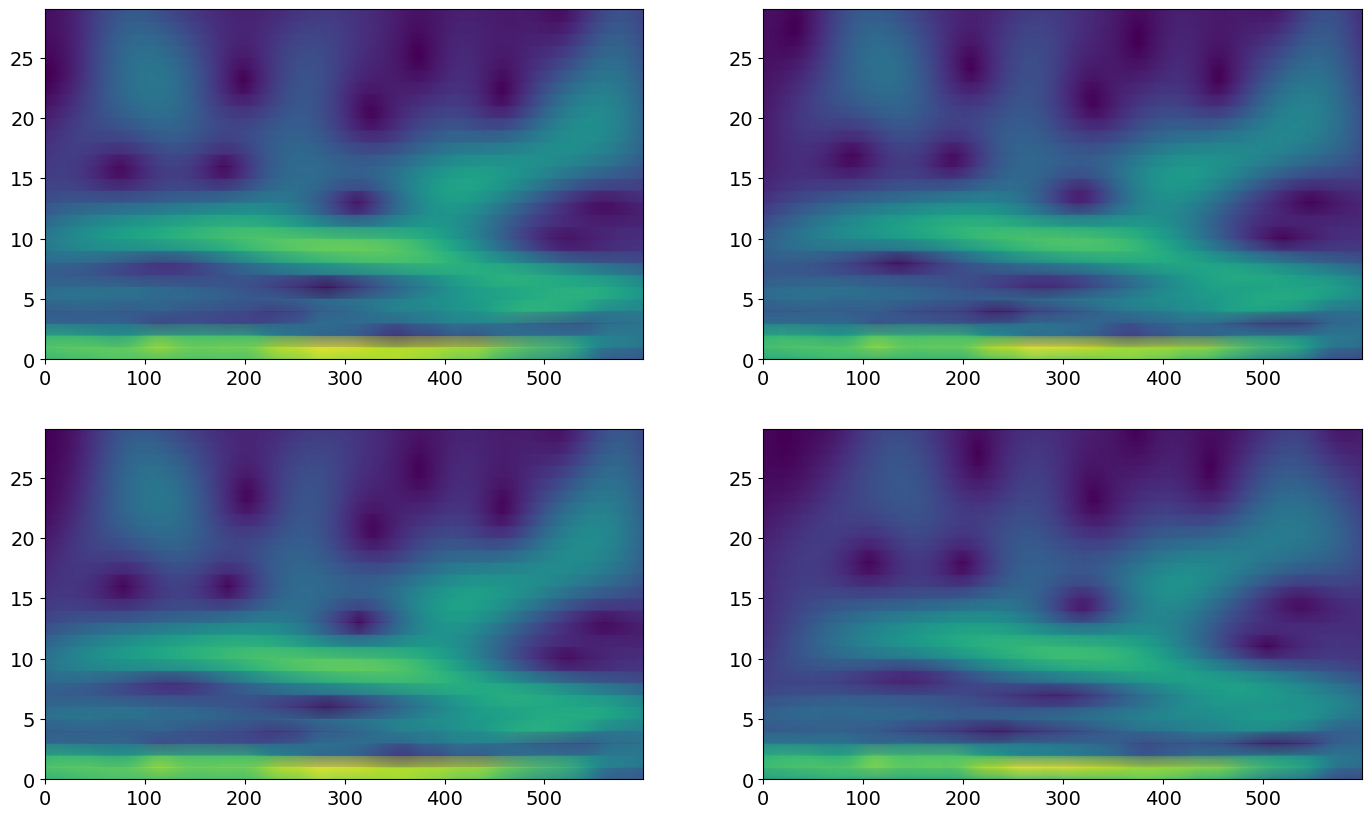

In [ ]:
# выведем первую спектограмму

index = 1

plt.rcParams["figure.figsize"] = (17, 10)
plt.rcParams["font.size"] = 14
fig, axs = plt.subplots(2, 2)

for channel in range(4):
    value = person_spectrograms[index+4][channel]

    axs[channel % 2][channel // 2].pcolormesh( value, cmap='viridis', shading='gouraud')

plt.show()

## Подготовка Dataset из спектограмм


In [ ]:
def train_test_split(labels, morlets, test_size):
    indices = np.arange(len(morlets))
    np.random.shuffle(indices)

    labels = np.array(labels)[indices]
    morlets =  morlets[indices]
    train_count = int(len(morlets) * (1.0 - test_size))

    train_labels, train_morlets = labels[0:train_count], morlets[0:train_count]
    test_labels, test_morlets = labels[train_count:-1], morlets[train_count:-1]
    return train_labels, train_morlets, test_labels, test_morlets

In [ ]:
class NoiseTransform(object):

    def __init__(self, noise_scale):
        self.noise_scale = noise_scale

    def __call__(self, sample):
        morlet = sample
        return morlet + np.random.normal(0, self.noise_scale, morlet.shape)


class ToTensor(object):

    def __call__(self, sample):
        morlet = sample

        return torch.from_numpy(morlet.copy())

In [ ]:
class PSDataset(Dataset):  # Person Spectrograms Dataset

    def __init__(self, labels, spectrograms, transform=None, target_transform=None):
        self.labels = labels
        self.spectrograms = spectrograms
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        spectrogram, label = self.spectrograms[idx], self.labels[idx]
        if self.transform:
            spectrogram = self.transform(spectrogram)
        if self.target_transform:
            label = self.target_transform(label)
        return spectrogram, label


In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__  = dict.get
    __setattr__  = dict.__setitem__
    __delattr__  = dict.__delitem__

    def copy(self):
        my_copy = type(self)()
        for k, v in self.items():
            my_copy[k] = v
        return my_copy

In [ ]:
# настройки для модели
test_config = dotdict()

# Train properties
test_config.test_size         = 0.2
test_config.batch_size        = 8
test_config.epochs            = 50
test_config.use_conv_sigmoid  = False
test_config.use_dense_sigmoid = False # test_config.binary

# Train autoconfig
test_config.lr_step_size     = 40
test_config.lr_start         = 0.01

# Transform properties
test_config.shift_transform_scale = 1.1
test_config.shift_transform_roll  = 1.0
test_config.noise_transform_scale = 0.00001
test_config.make_flip_along_time  = False

test_config.seed       = 42
test_config.seed_steps = 1

In [ ]:
#train_labels, train_morlets, test_labels, test_morlets = train_test_split(labels, person_spectrograms, test_config.test_size)

In [ ]:
with open('train_test_split.json', 'r') as file:
    python_obj = json.load(file)

i_person = 0
X_train_sectors = python_obj[f'{i_person}']['X_train_sectors']
X_test_sectors = python_obj[f'{i_person}']['X_test_sectors']
y_train = python_obj[f'{i_person}']['y_train']
y_test = np.array(python_obj[f'{i_person}']['y_test'])

labels = np.array(labels)
person_spectrograms = np.array(person_spectrograms)

train_labels = labels[X_train_sectors]
train_morlets = person_spectrograms[X_train_sectors]
test_labels = labels[X_test_sectors]
test_morlets = person_spectrograms[X_test_sectors]

In [ ]:
train_transform = torchvision.transforms.Compose([
    #NoiseTransform(test_config.noise_transform_scale),
    ToTensor(),
    torchvision.transforms.Resize((128, 512), torchvision.transforms.InterpolationMode.BICUBIC ),
    torchvision.transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 0.3))
])

test_transform = torchvision.transforms.Compose([
    ToTensor(),
    torchvision.transforms.Resize((128, 512), torchvision.transforms.InterpolationMode.BICUBIC ),

])


train_data = PSDataset(train_labels, train_morlets, train_transform)
test_data = PSDataset(test_labels, test_morlets, test_transform)

print(f'Размер входных данных - {len(train_data.spectrograms[0])}, { len(train_data.spectrograms[0][0])},  {len(train_data.spectrograms[0][0][0])}')

train_loader = DataLoader(train_data, batch_size = test_config.batch_size, shuffle=True)
test_loader = DataLoader(test_data, shuffle=False)

In [ ]:
train_morlets.shape

In [ ]:
train_data[0][0].shape

Демонстрация трансормации спектограммы:

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 14
fig, axs = plt.subplots(1, 2)

axs[0].pcolormesh( train_morlets[0][0])
axs[1].pcolormesh( train_data[0][0][0])

plt.show()

#Работа с моделями


In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('epoch')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  def display(self,groups = None):
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [ ]:
!python -m pip install git+https://github.com/lessw2020/Ranger21.git

## ResNet18


In [ ]:
! pip3 install timm
import timm

In [ ]:
from sklearn.metrics import f1_score

def calculate_f1score(model, test_dataset):
    f1 = 0

    with torch.no_grad():
        model.eval()
        for morlet, label in test_dataset:
            output = model(morlet[...].float().to(device))

            predicted = torch.argmax(output, 1)
            f1 += f1_score(label, predicted.cpu().detach().numpy(), average='weighted')

    return f1 / len(test_dataset)

In [ ]:
def calculate_accuracy(model, test_dataset, criterion, device):

    total_correct, total_instances, ep_loss = 0, 0, 0

    with torch.no_grad():

        model.eval()
        for morlets, labels in test_dataset:
            morlets = morlets.float()

            morlets, labels = morlets.to(device), labels.to(device)

            logits = model(morlets)
            loss = criterion(logits, labels)

            ep_loss += loss.item()

            predicted = torch.argmax(logits, dim=1)

            total_correct += sum(predicted == labels).item()
            total_instances+=len(labels)

    return total_correct/ total_instances,  ep_loss/ total_instances

In [ ]:
def train_model_plot(model , train_loader, test_loader, device, optimizer, criterion, epochs, scheduler = None):
    pp = ProgressPlotter()
    for epoch in range(epochs):

        total_correct, total_instances, ep_loss = 0, 0, 0
        model.train()
        for iter,  batch in enumerate(train_loader):

            morlets, labels =  batch
            morlets = morlets.float()
            morlets, labels = morlets.to(device), labels.to(device)

            optimizer.zero_grad()

            logits = model(morlets)
            loss = criterion(logits, labels) # Многоклассовая

            loss.backward()
            optimizer.step()

            ep_loss += loss.item()

            predicted = torch.argmax(logits, dim=1)

            total_correct += sum(predicted == labels).item()
            total_instances+=len(labels)

        if scheduler is not None:
            scheduler.step()

        # Logging
        pp.add_scalar('loss_train', ep_loss/ total_instances)
        pp.add_scalar('accuracy_train', total_correct/ total_instances)

        accuracy, loss_val = calculate_accuracy(model, test_loader, criterion, device)
        pp.add_scalar('loss_val',loss_val)
        pp.add_scalar('accuracy_val',accuracy)

        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
    return pp

In [ ]:
def train_model(model , train_loader, device, optimizer, criterion, epochs, scheduler = None):

    for epoch in range(epochs):
        correct, total, ep_loss = 0, 0, 0
        model.train()
        for iter,  batch in enumerate(train_loader):

            morlets, labels =  batch
            morlets = morlets.float()

            logits = model(morlets.to(device))

            if logits.shape[-1] == 1: # бинарная
                logits = torch.sigmoid(logits.flatten())
                labels = labels.float()
                loss = criterion(logits, labels.to(device))
            else:
                loss = criterion(logits, labels.to(device)) # Многоклассовая

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler is not None:
            scheduler.step()

In [ ]:
class Identity( torch.nn.Module ):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

### Пример бинарной классификации ResNet ( не запускать - не работает с текущими функциями )

In [ ]:
def made_dataset_for_one_person_BINARclassif(edf_person, label0, label1, seed = 42):

    segments, all_labels = get_person_segments(edf_person, target_channels = TARGET_CHANNEL_SETS )
    all_labels = normalize_labels(all_labels, MIN_PHONEME_ID )

    segments = make_segments_centered(segments)[0:4]

    i_label0 = 0
    i_label1 = 2

    tuple0, tuple1 = get_two_segments_by_labels(segments, all_labels, label0 = i_label0, label1 = i_label1)

    segments0, labels0 = tuple0
    segments1, labels1 = tuple1

    person_spectrograms0 = normalize_spectrograms(convert_person_segments_to_spectrograms(segments0))
    person_spectrograms1 = normalize_spectrograms(convert_person_segments_to_spectrograms(segments1))

    person_spectrograms = np.array([ *person_spectrograms0, *person_spectrograms1 ])
    labels =  np.array([*labels0, *labels1])

    train_labels, train_morlets, test_labels, test_morlets = train_test_split(labels, person_spectrograms, test_config.test_size)
    print(f'Метки в test - {test_labels}')

    train_transform = torchvision.transforms.Compose([
        NoiseTransform(test_config.noise_transform_scale),

        ToTensor(),
    ])

    test_transform = torchvision.transforms.Compose([
        ToTensor()
    ])

    train_data = PSDataset(train_labels, train_morlets, train_transform)
    test_data = PSDataset(test_labels, test_morlets, test_transform)

    train_loader = DataLoader(train_data,
                        batch_size=8, shuffle=True)

    test_loader = DataLoader(test_data, shuffle=False)

    return train_loader, test_loader

In [ ]:
# Бинарная классификация фонем /А/ и /Б/ испытуемого 1
edf_person = edf_prosebaya[0]
num_classes = 1

label0 = 0
label1 = 2

train_loader, test_loader =  made_dataset_for_one_person_BINARclassif(edf_person, label0, label1)

In [ ]:
model = timm.create_model('resnet18',  pretrained=True, num_classes=1 )
model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), bias=False)

print(f'  MODEL  - {model}')

optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
criterion = torch.nn.BCELoss()

train_model(model, train_loader, optimizer,  criterion, 40 )
result_match = calculate_match_on_dataset(model, test_loader) * 100

print(f'MATCH: {round(result_match, 2)}% ')

### Пример многоклассовой классификации ResNet

In [ ]:
def train_test_split_fix(i_person, labels, person_spectrograms):
    with open('train_test_split.json', 'r') as file:
        python_obj = json.load(file)

    X_train_sectors = python_obj[f'{i_person}']['X_train_sectors']
    X_test_sectors = python_obj[f'{i_person}']['X_test_sectors']
    y_train = python_obj[f'{i_person}']['y_train']
    y_test = np.array(python_obj[f'{i_person}']['y_test'])

    labels = np.array(labels)
    person_spectrograms = np.array(person_spectrograms)

    train_labels = labels[X_train_sectors]
    train_morlets = person_spectrograms[X_train_sectors]
    test_labels = labels[X_test_sectors]
    test_morlets = person_spectrograms[X_test_sectors]
    return train_labels, train_morlets, test_labels, test_morlets

In [ ]:
def made_dataset_for_one_person_MULTclassif(edf_person, i_person, target_channels = TARGET_CHANNELS, seed = 42):

    new_size = (128, 512)

    segments, labels = get_person_segments(edf_person,  target_channels = TARGET_CHANNEL_SETS )
    labels = normalize_labels(labels, MIN_PHONEME_ID )

    new_segments = DWT(segments)

    #segments = make_segments_centered(new_segments)[0:target_channels] # ЭМГ - индикатор

    person_spectrograms = convert_person_segments_to_spectrograms(new_segments)
    person_spectrograms = normalize_spectrograms(person_spectrograms)

    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Split
    train_labels, train_morlets, test_labels, test_morlets = train_test_split_fix(i_person,labels, person_spectrograms)

    train_transform = torchvision.transforms.Compose([
        #NoiseTransform(test_config.noise_transform_scale),
        ToTensor(),
        #torchvision.transforms.Resize(new_size, torchvision.transforms.InterpolationMode.BICUBIC ),
        torchvision.transforms.GaussianBlur(kernel_size = 5, sigma=(0.1, 0.3))

    ])

    test_transform = torchvision.transforms.Compose([
        ToTensor(),
        #torchvision.transforms.Resize(new_size, torchvision.transforms.InterpolationMode.BICUBIC ),

    ])

    #print(f'Размер входных данных - {len(train_morlets[0])}, { len(train_morlets[0][0])},  { len(train_morlets[0][0][0])}')
    train_data = PSDataset(train_labels, train_morlets, transform = train_transform)
    test_data = PSDataset(test_labels, test_morlets, transform = test_transform)

    train_loader = DataLoader(train_data,
                        batch_size=8, shuffle=True)
    test_loader = DataLoader(test_data, shuffle=False)

    #print(f'Испытуемый - {edf_person}')
    #print(f'Всего данных - {len(person_spectrograms)}, test - {len(train_data)} train - {len(test_data)}')

    return train_loader, test_loader

In [ ]:
edf_person = edf_prosebaya[0]
train_loader, test_loader =  made_dataset_for_one_person_MULTclassif(edf_person, 0 )

Настроим модель

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

In [ ]:
from torchsummary import summary

num_classes = 7

model = timm.create_model('resnet18',  pretrained=True, num_classes=num_classes)
model.conv1 = torch.nn.Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), bias=False)
model.fc = torch.nn.Linear(in_features=256, out_features=7, bias=True)
model.layer4 = Identity()

model.to(device)
#print(f'  MODEL  - {model}')
#summary(model,( len(train_morlets[0]), len(train_morlets[0][0]), len(train_morlets[0][0][0])))

Обучение

In [ ]:
from ranger21 import Ranger21

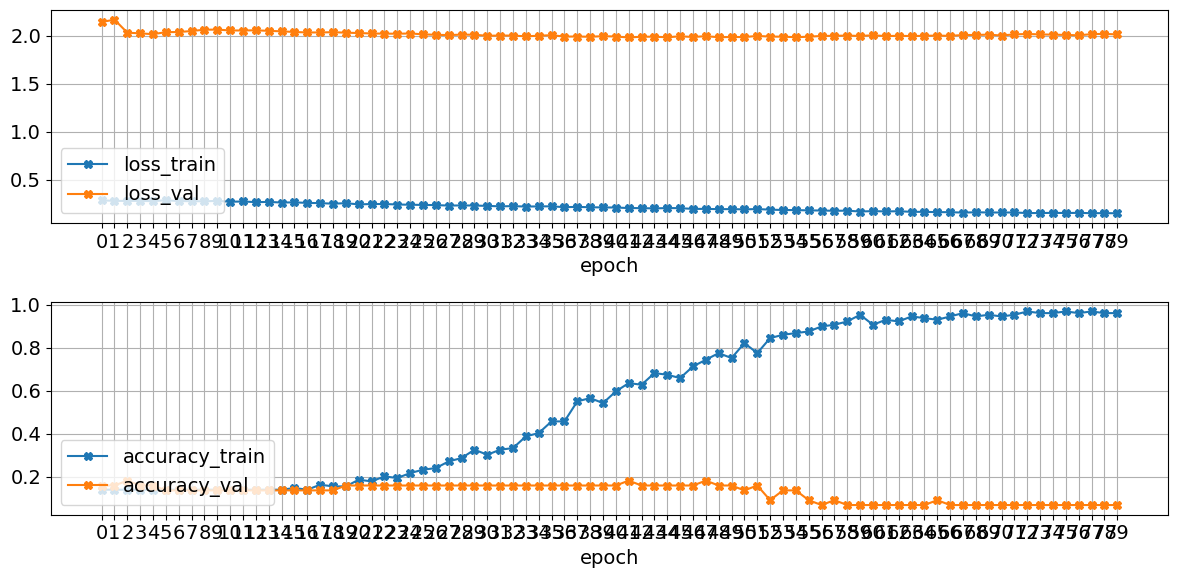

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
epochs = 40

optimizer = Ranger21(model.parameters(), lr = 0.001, num_epochs = epochs, num_batches_per_epoch = len(train_loader))
criterion = torch.nn.CrossEntropyLoss()

pp = train_model_plot(model, train_loader, test_loader, device, optimizer,  criterion, epochs = epochs )

In [ ]:
result_match = calculate_match_on_dataset(model, test_loader) * 100

print(f'MATCH: {round(result_match, 2)}% ')

## EfficientNet B0

### Пример многоклассовой классификации ResNet

In [ ]:
edf_person = edf_prosebaya[0]
train_loader, test_loader =  made_dataset_for_one_person_MULTclassif(edf_person, 0)

In [ ]:
num_classes = 7
model = timm.create_model('tf_efficientnet_b0',  pretrained=True, num_classes=num_classes)

In [ ]:
from torchsummary import summary

model.conv_stem = torch.nn.Conv2d(24, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
#model.blocks[3] = Identity()
model.blocks[4] = Identity()
model.blocks[5] = Identity()
model.blocks[6] = Identity()
model.conv_head = torch.nn.Conv2d(80, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)

model.to(device)
#print(f'  MODEL  - {model}')

Обучение

In [ ]:
epochs = 40

optimizer = Ranger21(model.parameters(), lr = 0.005, num_epochs = epochs, num_batches_per_epoch = len(train_loader))
criterion = torch.nn.CrossEntropyLoss()

pp = train_model_plot(model, train_loader, test_loader, device, optimizer,  criterion, epochs = epochs )